This file is to test the micrograd on a more complex toy dataset.

In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt
from micrograd.nn import Module, MLP
from micrograd.engine import Value
%matplotlib inline

In [31]:
np.random.seed(444)
random.seed(444)

In [32]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=200, noise=0.1)
print(X.shape, y.shape)

(200, 2) (200,)


In [33]:
np.unique(y)

array([0, 1])

In [34]:
y = 2 * y - 1 # changing class representation of 0 to -1 for hinge loss
np.unique(y)

array([-1,  1])

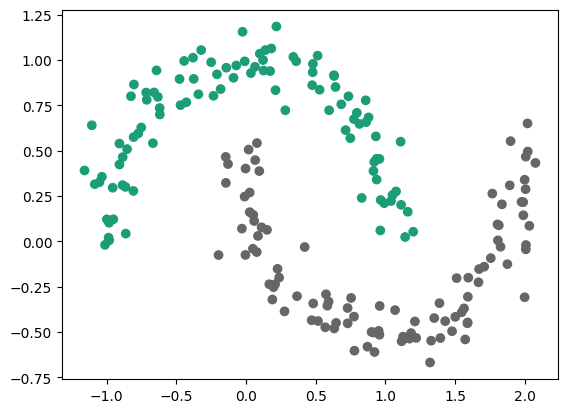

In [35]:
# Visualizing the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Dark2')

In [36]:
# initializing the model
model = MLP(2, [16, 16, 1])
print(model)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)]
Layer of [LinearNeuron(16)]
]


define a new loss function.\
From the visualization of the dataset, we can see that the datapoints can be seperated by a hyperplane. So we can take a SVM type approach.\
For that we will implement hinge loss\
hinge Loss: L = max(0, 1 - y*y')\
this is used for binary classification. Labels (y) should be -1 and 1 and model outputs (y') should be linear.\
intuition\
For the loss to be 0, y*y' should be >= 1\
so, for class +1, y * y' >= 1, or y' >= 1\
similarly for class -1, y * y' >= 1, or y <= -1\
These are highly confident predictions\
in case of 0 < y*y' < 1, loss is +ve. We are getting right predictions, but they are not highly confident, hence penalized.\
Higher the difference between true label and y', higher the y*y', hence, higher the penalization.

In [37]:
# BCE loss
def bce(ytrue, ypred): # make sure that labels are 0 and 1
    bce = -np.mean(ytrue * np.log(ypred) + (1-ytrue)*np.log(1-ypred))
    return bce

# Hinge Loss
def hinge_loss(ytrue, ypred):
    data_loss = sum((1 - ygt*yout).relu() for ygt, yout in zip(ytrue, ypred))  # relu() is also maxing it from (0, +val)
    data_loss = data_loss * (1/len(ytrue))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in model.parameters())
    total_loss = data_loss + reg_loss
    
    accuracy = [(yi.data>0) == (yr>0) for yi, yr in zip(ypred, ytrue)]
    accuracy = sum(accuracy)/len(accuracy)
    return total_loss, accuracy

In [38]:
# hyperparameters of the model
lr = 0.075
steps = 200

# training loop
for k in range(steps):
    # forward pass for Hinge Loss
    yhat = [model(x) for x in X]
    loss, accuracy = hinge_loss(y, yhat)
    # forward pass for BCE
    # yhat = [model(x).sigmoid() for x in X]  # since we are using BCE loss, we need probabilities, hence applying sigmoid to the output
    # loss = sum(((ygt* (yout.log()) + (1-ygt)*((1-yout).log())) for yout, ygt in zip(yhat, y)), Value(0))
    # loss = -loss/len(yhat)
    
    # backward pass
    model.zero_grad()
    loss.backward()
    
    # value update
    for p in model.parameters():
        p.data += -lr * p.grad
    
    print(f'step {k}, Loss: {loss.data}, Accuracy: {accuracy*100}%')

step 0, Loss: 1.5787875970738543, Accuracy: 50.0%
step 1, Loss: 1.4049690382022846, Accuracy: 50.0%
step 2, Loss: 1.258138864102411, Accuracy: 52.5%
step 3, Loss: 1.1260735299870621, Accuracy: 55.50000000000001%
step 4, Loss: 1.005100825338594, Accuracy: 59.5%
step 5, Loss: 0.8972354296633523, Accuracy: 61.0%
step 6, Loss: 0.8126202096837483, Accuracy: 63.0%
step 7, Loss: 0.7512215666349215, Accuracy: 65.5%
step 8, Loss: 0.7028594071589667, Accuracy: 66.5%
step 9, Loss: 0.6609704498086049, Accuracy: 66.5%
step 10, Loss: 0.626556977728081, Accuracy: 67.5%
step 11, Loss: 0.5969895232880343, Accuracy: 68.0%
step 12, Loss: 0.5692971479375616, Accuracy: 69.5%
step 13, Loss: 0.5439296374514587, Accuracy: 70.0%
step 14, Loss: 0.5202578881838826, Accuracy: 71.0%
step 15, Loss: 0.49784187924688117, Accuracy: 78.0%
step 16, Loss: 0.47605446232537146, Accuracy: 80.5%
step 17, Loss: 0.45511964588239306, Accuracy: 82.0%
step 18, Loss: 0.43517645323871945, Accuracy: 83.5%
step 19, Loss: 0.4149448184

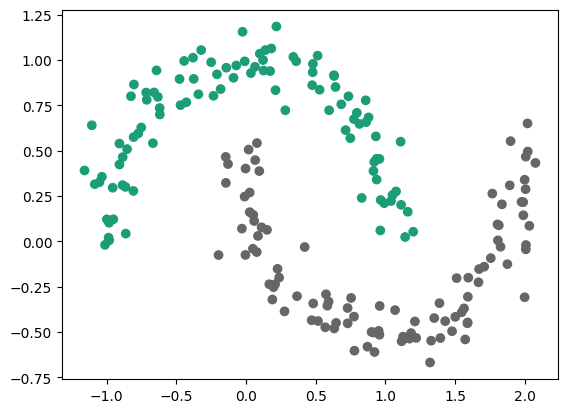

In [39]:
ypred = [1 if model(x).sigmoid().data > 0.5 else 0 for x in X]
# plt.plot(ypred)
plt.scatter(X[:, 0], X[:, 1], c=ypred, cmap='Dark2')

(-1.668836365518903, 2.081163634481097)

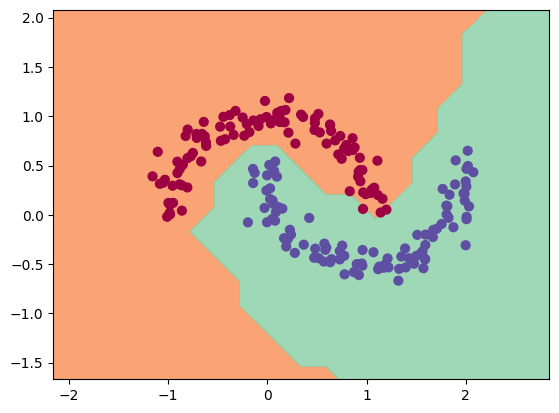

In [40]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())